Creating vocabulary...
Vocabulary size: 100

Creating training corpus...
Number of sentences: 50

Creating training pairs...
Number of training pairs: 324

Training Skip-gram model...
Epoch 0, Loss: 4.6051
Epoch 100, Loss: 2.9305
Epoch 200, Loss: 2.0890
Epoch 300, Loss: 1.9968
Epoch 400, Loss: 1.9840

Testing word similarities:

Words similar to 'cat':
  woman: 0.857
  friend: 0.766
  book: 0.644
  food: 0.627
  tree: 0.577

Words similar to 'dog':
  park: 0.680
  woman: 0.666
  car: 0.640
  tree: 0.604
  book: 0.566

Words similar to 'house':
  car: 0.900
  book: 0.830
  country: 0.810
  woman: 0.748
  tree: 0.704

Words similar to 'run':
  likes: 0.708
  friend: 0.637
  he: 0.491
  plays: 0.398
  walk: 0.340

Words similar to 'eat':
  like: 0.699
  food: 0.598
  love: 0.593
  live: 0.572
  play: 0.492


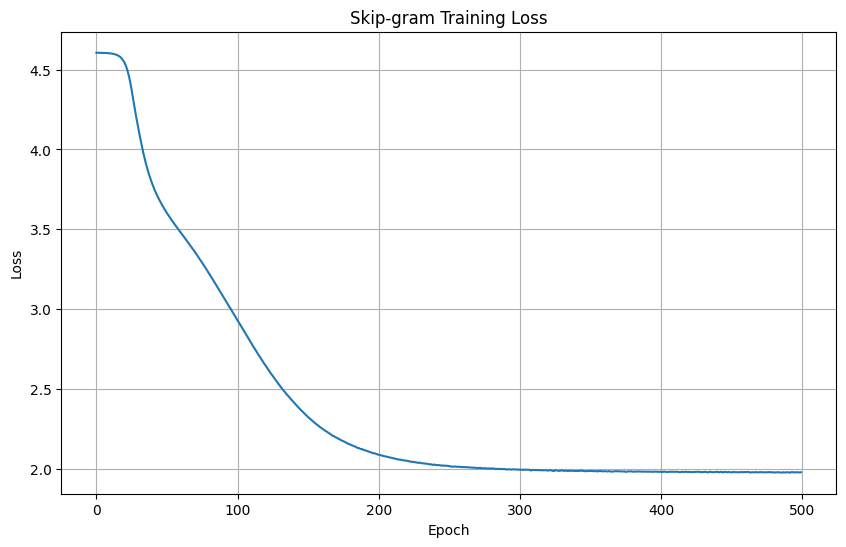


Embedding shape for each word: (50,)
Word embeddings trained successfully!


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import random

class SkipGram:
    def __init__(self, vocab_size, embedding_dim=50, window_size=2, learning_rate=0.01):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.window_size = window_size
        self.learning_rate = learning_rate

        # Embedding matrix <-> W_in
        self.W_in = np.random.randn(vocab_size, embedding_dim) * 0.01

        self.W_out = np.random.randn(embedding_dim, vocab_size) * 0.01

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x)) # subtracting with max(x) to make it numerically stable (prevent overflow)
        return exp_x / np.sum(exp_x)

    def forward(self, center_word_idx, context_word_idx):

        # extracting embedding at point of time t (at t = 0 -> its a one-hot vector)
        h = self.W_in[center_word_idx]  # (embedding_dim,)

        # computing z = W*ej + b -> b = 0 -> z = W*ej -> ej = h -> z = W*h
        u = np.dot(self.W_out.T, h)  # (vocab_size,)

        # Apply softmax
        y_pred = self.softmax(u)

        # Compute loss (negative log likelihood)
        loss = -np.log(y_pred[context_word_idx] + 1e-8)

        return h, u, y_pred, loss

    def backward(self, center_word_idx, context_word_idx, h, u, y_pred):

        y_true = np.zeros(self.vocab_size)
        y_true[context_word_idx] = 1

        # Gradient of loss w.r.t. output scores
        dL_du = y_pred - y_true  # (vocab_size,)

        # h = ej
        dL_dW_out = np.outer(h, dL_du)  # (embedding_dim, vocab_size)

        # Gradient w.r.t. hidden layer (center word embedding)
        dL_dh = np.dot(self.W_out, dL_du)  # (embedding_dim,)

        # Update weights
        self.W_out -= self.learning_rate * dL_dW_out
        self.W_in[center_word_idx] -= self.learning_rate * dL_dh

        return dL_dW_out, dL_dh

    def train(self, training_pairs, epochs=1000):
        """Train the skip-gram model"""
        losses = []

        for epoch in range(epochs):
            total_loss = 0
            random.shuffle(training_pairs)

            for center_idx, context_idx in training_pairs:
                h, u, y_pred, loss = self.forward(center_idx, context_idx)
                self.backward(center_idx, context_idx, h, u, y_pred)
                total_loss += loss

            avg_loss = total_loss / len(training_pairs)
            losses.append(avg_loss)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

        return losses

    def get_word_embedding(self, word_idx):
        return self.W_in[word_idx]

    def get_similar_words(self, word_idx, word_to_idx, idx_to_word, top_k=5):
        target_embedding = self.W_in[word_idx]

        similarities = []
        for i in range(self.vocab_size):
            if i != word_idx:
                embedding = self.W_in[i]
                # Cosine similarity
                similarity = np.dot(target_embedding, embedding) / (
                    np.linalg.norm(target_embedding) * np.linalg.norm(embedding) + 1e-8
                )
                similarities.append((i, similarity))

        similarities.sort(key=lambda x: x[1], reverse=True)

        return [(idx_to_word[idx], sim) for idx, sim in similarities[:top_k]]

def create_vocabulary():
    """Create a small but meaningful vocabulary"""
    vocab = [
        # Articles
        'the', 'a', 'an',
        # Pronouns
        'i', 'you', 'he', 'she', 'it', 'we', 'they',
        # Verbs
        'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
        'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would',
        'can', 'could', 'should', 'must', 'may', 'might',
        'go', 'goes', 'went', 'gone', 'going',
        'see', 'sees', 'saw', 'seen', 'seeing',
        'like', 'likes', 'liked', 'liking',
        'eat', 'eats', 'ate', 'eaten', 'eating',
        'play', 'plays', 'played', 'playing',
        'run', 'runs', 'ran', 'running',
        'walk', 'walks', 'walked', 'walking',
        'talk', 'talks', 'talked', 'talking',
        'work', 'works', 'worked', 'working',
        'live', 'lives', 'lived', 'living',
        'love', 'loves', 'loved', 'loving',
        # Nouns
        'cat', 'dog', 'house', 'car', 'book', 'food', 'water', 'tree',
        'man', 'woman', 'child', 'people', 'friend', 'family',
        'school', 'home', 'park', 'city', 'country',
        'day', 'night', 'time', 'year', 'week',
        # Adjectives
        'good', 'bad', 'big', 'small', 'new', 'old', 'happy', 'sad',
        'fast', 'slow', 'hot', 'cold', 'beautiful', 'ugly',
        # Adverbs
        'very', 'really', 'quite', 'always', 'never', 'sometimes',
        'here', 'there', 'now', 'then', 'today', 'yesterday', 'tomorrow',
        # Prepositions
        'in', 'on', 'at', 'to', 'from', 'with', 'by', 'for', 'of', 'about'
    ]

    # Ensure we have exactly 100 words
    vocab = vocab[:100]

    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}

    return vocab, word_to_idx, idx_to_word

def create_training_corpus():
    """Create a training corpus with meaningful sentences"""
    sentences = [
        "the cat is very happy",
        "a dog runs in the park",
        "i like to eat good food",
        "she walks to school every day",
        "we live in a big house",
        "the book is really interesting",
        "he plays with his friend",
        "they work in the city",
        "the weather is quite hot today",
        "i can see a beautiful tree",
        "the child loves to play",
        "we go to the park sometimes",
        "she has a small car",
        "the man talks about work",
        "i am going home now",
        "the family lives here",
        "he likes to run fast",
        "they eat at the restaurant",
        "the woman is very kind",
        "we should go there tomorrow",
        "the dog is quite small",
        "i love to read books",
        "she works very hard",
        "the house is really old",
        "he can walk to school",
        "they play in the garden",
        "the cat sleeps on the bed",
        "we have a good time",
        "the food is very delicious",
        "i see the beautiful sunset",
        "she runs every morning",
        "the car is quite new",
        "he talks to his friends",
        "they live in the country",
        "the tree is very tall",
        "i like the warm weather",
        "she goes to work early",
        "we play games together",
        "the book has good stories",
        "the dog barks at night",
        "i walk to the store",
        "she loves her family",
        "the man drives fast",
        "they eat lunch together",
        "the house has big windows",
        "i can see the mountains",
        "she works at the hospital",
        "the cat plays with yarn",
        "we go shopping today",
        "the weather is cold now"
    ]

    return sentences

def create_training_pairs(sentences, word_to_idx, window_size=2):
    """Create training pairs for skip-gram"""
    training_pairs = []

    for sentence in sentences:
        words = sentence.split()
        word_indices = [word_to_idx[word] for word in words if word in word_to_idx]

        for i, center_word in enumerate(word_indices):
            # Define context window
            start = max(0, i - window_size)
            end = min(len(word_indices), i + window_size + 1)

            for j in range(start, end):
                if i != j:  # Skip the center word itself
                    context_word = word_indices[j]
                    training_pairs.append((center_word, context_word))

    return training_pairs

def train_word_embeddings():
    """Train word embeddings using skip-gram"""
    print("Creating vocabulary...")
    vocab, word_to_idx, idx_to_word = create_vocabulary()
    print(f"Vocabulary size: {len(vocab)}")

    print("\nCreating training corpus...")
    sentences = create_training_corpus()
    print(f"Number of sentences: {len(sentences)}")

    print("\nCreating training pairs...")
    training_pairs = create_training_pairs(sentences, word_to_idx)
    print(f"Number of training pairs: {len(training_pairs)}")

    print("\nTraining Skip-gram model...")
    skipgram = SkipGram(vocab_size=len(vocab), embedding_dim=50, window_size=2, learning_rate=0.01)
    losses = skipgram.train(training_pairs, epochs=500)

    return skipgram, vocab, word_to_idx, idx_to_word, losses

def test_embeddings(skipgram, word_to_idx, idx_to_word):
    """Test the trained word embeddings"""
    test_words = ['cat', 'dog', 'house', 'happy', 'run', 'eat']

    print("\nTesting word similarities:")
    for word in test_words:
        if word in word_to_idx:
            word_idx = word_to_idx[word]
            similar_words = skipgram.get_similar_words(word_idx, word_to_idx, idx_to_word)
            print(f"\nWords similar to '{word}':")
            for sim_word, similarity in similar_words:
                print(f"  {sim_word}: {similarity:.3f}")


if __name__ == "__main__":
    # Train word embeddings
    skipgram, vocab, word_to_idx, idx_to_word, losses = train_word_embeddings()

    # Test embeddings
    test_embeddings(skipgram, word_to_idx, idx_to_word)

    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Skip-gram Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()


    print(f"\nEmbedding shape for each word: {skipgram.get_word_embedding(0).shape}")
    print("Word embeddings trained successfully!")

In [3]:
word_to_idx['car']

82

In [4]:
embedding_matrix = skipgram.W_in

In [5]:
# embedding of word: 'car'
embedding_matrix[word_to_idx['car']] # 50 dimensions

array([ 0.62612501,  0.17071079,  0.46190089, -0.42935168, -0.38031045,
        0.53894784,  0.32915612,  0.44976648, -0.51539218,  0.30035839,
       -0.05158959, -0.56953659,  0.23069938, -0.61746341,  0.53374164,
        0.32903504, -0.73235234,  0.03967448,  0.14790209,  0.42197827,
        0.32038985,  0.40178467, -1.02779309,  0.13433398,  0.30141085,
       -0.6443488 ,  0.29567413, -0.72701682, -0.03879093, -0.16026256,
       -0.29664928, -0.04607894, -0.27878037,  0.44396757, -0.46143382,
        0.06215249,  0.41389026, -0.18234623,  0.23285965, -0.47383208,
        0.34399005, -1.41971947, -0.06125847, -0.45225527,  0.40036709,
       -0.11051104, -0.10960215,  0.38835865,  0.46191064, -0.36138614])